In [2]:
import cv2
import os
import numpy as np
import random
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.models import model_from_json
import requests
import urllib.request
from PIL import Image
import io
import random


Using TensorFlow backend.


In [0]:
def load_images_from_folder(folder, num):   #written by us
    img = []
    csv = np.genfromtxt('test-images-with-rotation.csv',dtype='str')
    for i in range(0,num):
      response = requests.get(csv[i])
      images = Image.open(io.BytesIO(response.content))
      img.append(images)      
    return img



In [0]:
def blur_images(images):
    dataset = []
    for im in images:
      t=[]
      t.append(im)
      rand = random.randint(1,10)
      blur = cv2.blur(np.array(im), (rand,rand),0)
      #blur = im #image
      t.append(blur)
      dataset.append(t)
    random.shuffle(dataset)
    return dataset

In [0]:
def create_training_dev_set(folder,size_train, size_dev):
    """
    This function loads images from the folder 
    and the training and dev set of required size

    Arguments:
    folder: a string containing the name of the folder
    to load images from 
    size_train: number of samples needed in the training set
    size_dev: number of samples needed in the dev set
    
    Outputs:
    X_train: list of training blur images
    Y_train: list of training clear images
    X_dev: list of dev blur images
    Y_dev: list of dev clear images
    """
    images = load_images_from_folder(folder, size_train + size_dev)
    data = blur_images(images)
    X_train1 = []
    Y_train1 = []
    X_dev1 = []
    Y_dev1 = []
    if size_train+size_dev != len(images):
        size_train = int(0.8 * len(images))
    a=data[0:size_train]
    for row in data[0:size_train]:
      X_train1.append(row[1])
      Y_train1.append(row[0])
    for row in data[0:size_train]:
      X_dev1.append(row[1])
      Y_dev1.append(row[0])

    X_train = []
    X_dev = []
    Y_train = []
    Y_dev = []
    patch=184
    c1=0
    c2=0
    for i in range(len(X_train1)):
        for j in range(int(np.array(X_train1[i]).shape[0]/patch)):
            for k in range(int(np.array(X_train1[i]).shape[1]/patch)):
              try:
                X_train.append(Image.fromarray(np.array(X_train1[i])[j*patch:(j+1)*patch,k*patch:(k+1)*patch,:]))
                Y_train.append(Image.fromarray(np.array(Y_train1[i])[j*patch:(j+1)*patch,k*patch:(k+1)*patch,:]))
              except IndexError:
                c1=c1+1
    print(c1)
    for i in range(len(X_dev1)):
        for j in range(int(np.array(X_dev1[i]).shape[0]/patch)):
            for k in range(int(np.array(X_dev1[i]).shape[1]/patch)):
              try:
                X_dev.append(Image.fromarray(np.array(X_dev1[i])[j*patch:(j+1)*patch,k*patch:(k+1)*patch,:]))
                Y_dev.append(Image.fromarray(np.array(Y_dev1[i])[j*patch:(j+1)*patch,k*patch:(k+1)*patch,:]))
              except IndexError:
                c2=c2+1
    print(c2)                
    return X_train, Y_train, X_dev, Y_dev



In [0]:
class Model(object):
	"""Definition for Model"""
	def __init__(self):
		super(Model, self).__init__()
		self.model = None

	def build_model(self):
		"""
		Builds a Keras model for de-blurring of images and returns the model

		Model details: Conv layer 1: 64 filters of size 9x9
					   Conv layer 2: 32 filters of size 1x1
					   Conv layer 3: 3 filters of size 5x5	
		"""
		self.model = Sequential()
		self.model.add(Conv2D(38, kernel_size=(121,1),activation='relu',padding = 'valid',input_shape=(184,184,3),data_format="channels_last",use_bias=True))
		self.model.add(Conv2D(38, (1,121), activation='relu',padding = 'valid',use_bias=True))
		self.model.add(Conv2D(3, (1,1), activation=None,padding = 'same',use_bias=True))
		self.model.compile(loss=keras.losses.mean_squared_error,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

	def load_model(self, model_name, weights_name):
		"""
		Loads a saved model along with it's weights from disk
		"""
		json_file = open(model_name, 'r')
		loaded_model_json = json_file.read()
		json_file.close()
		self.model = model_from_json(loaded_model_json)
		#	 load weights into new model
		self.model.load_weights(weights_name)
		print("Loaded model from disk")

	def save_model(self, model_name, weights_name):
		'''
		Saves the model and its weights to the disk
		'''
		model_json = self.model.to_json()
		with open(model_name, "w") as json_file:
		    json_file.write(model_json)
		# serialize weights to HDF5
		self.model.save_weights(weights_name)
		print("Saved model to disk")

	def compile_model(self):
		'''
		Compimes the given model
		Details: Loss-> MSE
				 Optimizer-> Adadelta
				 Metrics-> Accuracy
		'''
		self.model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

	def train_model(self,epochs,batch_size,X_train,X_dev,Y_train,Y_dev):
		'''
		Trains the given model as specified

		Arguments:

		model: model to be trained
		epochs: number of epochs to run training
		batch_size: batch size required to train
		X_train: Training images of size 32x32
		Y_train: Target clear images of size 32x32
		X_dev: Developement set of blur images
		Y_dev: Developement set of target images '''
		dev_X=[]
		dev_Y=[]
		for i in range(len(X_dev)):
			dev_X.append(np.array(X_dev[i]))
			dev_Y.append(np.array(Y_dev[i]))
		X=[]
		Y=[]
		for i in range(len(X_train)):
			X.append(np.array(X_train[i]))
			Y.append(np.array(Y_train[i]))
		self.model.fit(np.array(X), np.array(Y),
					batch_size=batch_size,
					epochs=epochs,
					verbose=1,
					validation_data=(np.array(dev_X), np.array(dev_Y)))

	def predict_deblur(self,img_path):
		'''
		Given a blur image, the function plots and saves the deblurred image
		'''

		img = cv2.imread(img_path)
		print (img.shape)
		img=Image.open(img_path)
		#im2 = img.copy()
		im2 = np.array(img)
		plt.imshow(im2)
		plt.figure()
		#img = np.asarray(img)
		#img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
		img = im2.astype('float32')
		img /= 255
		pred_img = img
		for x in range(int(img.shape[1]/20)-1):
			for y in range(int(img.shape[2]/20)-1):
				pred = self.model.predict(img[x*20:x*20 +32,y*20:y*20 + 32,:])
				pred_img[x*20 + 6:(x+1)*20 + 6,y*20 + 6:(y+1)*20 + 6,:] = pred[6:26,6:26,:]
				plt.imshow(img[x*20:x*20 +32,y*20:y*20 + 32,:])
				plt.show()
				plt.imshow(pred[6:26,6:26,:]*255)
				plt.figure()
		plt.show()
		plt.imshow(pred_img*255)
		plt.figure()
		plt.show()
		print(pred_img*255)

In [0]:
data_path = 'data'
training_size = 30
dev_size = 750
epochs = 50
batch_size = 500
model_name = 'model.json'
weights_name = "model.h5"

In [19]:
#Create training ad dev set
X_train, Y_train, X_dev, Y_dev = create_training_dev_set('unlabeled_images',training_size,dev_size)


8
8


In [1]:
deblur = Model()
deblur.build_model()
deblur.train_model(epochs,batch_size,X_train,X_dev,Y_train,Y_dev)
deblur.save_model(model_name, weights_name)


NameError: ignored

(220, 220, 3)


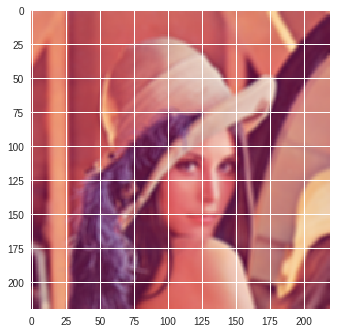

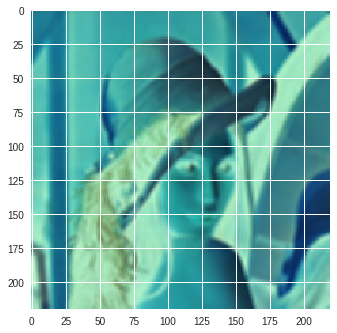

[[[225. 136. 124.]
  [225. 136. 124.]
  [226. 136. 123.]
  ...
  [209. 116. 109.]
  [212. 121. 110.]
  [218. 130. 115.]]

 [[225. 136. 124.]
  [225. 136. 124.]
  [226. 136. 123.]
  ...
  [209. 116. 109.]
  [212. 121. 110.]
  [218. 130. 115.]]

 [[225. 135. 121.]
  [225. 135. 121.]
  [226. 135. 120.]
  ...
  [194. 101. 101.]
  [188.  98. 100.]
  [186. 101. 101.]]

 ...

 [[ 95.  28.  63.]
  [ 95.  28.  63.]
  [ 96.  29.  63.]
  ...
  [117.  39.  66.]
  [128.  44.  68.]
  [134.  47.  69.]]

 [[ 93.  27.  62.]
  [ 93.  27.  62.]
  [ 94.  28.  62.]
  ...
  [128.  47.  71.]
  [142.  53.  73.]
  [151.  57.  74.]]

 [[ 92.  27.  61.]
  [ 92.  27.  61.]
  [ 93.  27.  62.]
  ...
  [135.  51.  74.]
  [150.  58.  76.]
  [160.  63.  78.]]]


In [22]:
deblur.predict_deblur('blur_lenna.png')